## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import cv2
from glob import glob
from collections import defaultdict

In [3]:
import torch

from numpy import floor

## Read imgs

construct the dict of imgs

In [4]:
def get_imgs_dict(path='img/numbers/'):
    
    char_img_paths = {}
    
    chars = ['-','.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9' ]
    
    for c in chars:
        char_img_paths[c] = glob(path + c +'*')
    
    
    char_img = defaultdict(list)

    for char, paths in char_img_paths.items():
        for path in paths:
            char_img[char].append( 
                cv2.cvtColor(
                    cv2.imread(path, cv2.IMREAD_UNCHANGED),
                cv2.COLOR_BGRA2RGBA
                )
            )
    return char_img

In [5]:
! ls ../input/numbers

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
char_img = get_imgs_dict('../input/numbers/numbers/')
char_img_test = get_imgs_dict('../input/numbers/numbers_test/')

### Paste images

In [7]:
def superimpose_img(background, img, topleft, char_size=(32,64)):
    '''
    background --- 4 chnl background
    img        --- the imge to be superimposed
    '''
    img = cv2.resize(img, char_size, interpolation=cv2.INTER_CUBIC)
    
    # use alpha channel to kill background 
    alpha = np.expand_dims(img[:,:,3], axis=2)
    alpha = alpha / np.max(alpha)
    img = img * alpha
    
    
    
    top, left = topleft
    height, width, _ = img.shape
    
    # remove the background where the symbol must be
    background[top:top + height, left:left+width] *= (1-alpha)
    
    # superimpose the image onto background
    background[top:top + height, left:left+width] += img
    
    return np.asarray(background, dtype = np.int32)

In [8]:
def random_stamp_numbers(char_img):
    '''
    Generate an image of random numbers drawn from img/numbers folder
    '''
    n_characters = 8
    char_width = 32
    char_height = 64
    spacing = 32
        
    
    background = np.ones((char_height, n_characters*char_width, 4))*255
    
    text = [] # GT text
    
    for n in range(8):
        number = np.random.randint(0, 9+1)
        char = str(number)
        text.append(char)
        
        # select the character example
        n_examples = len(char_img[char])
        if n_examples > 1:
            example_idx = np.random.randint(0, n_examples-1 )
        else:
            example_idx = 0
        
        
        img2 = superimpose_img((background), np.copy(char_img[char][example_idx]), (0,spacing*n))
        
        # rgba to rgb       
        img2 = cv2.cvtColor(np.uint8(img2), cv2.COLOR_RGBA2RGB)
        
    return img2, text

# plt.imshow(img2)
# plt.show()

In [9]:
# plt.imshow(char_img['4'][0][:,:, 3])

In [10]:
# img, text = random_stamp_numbers(char_img_test)
# plt.imshow(img)
# print(text)

## Generator

### Globals

In [11]:
text_to_idx ={
    '0':0, '1':1, '2':2, '3':3, '4':4, '5':5, '6':6, '7':7, '8':8, '9':9,
#     '-','.' 
}

In [12]:
def text_to_y(y, text, N):
    '''
    y[batch_idx, character class, character position]
    convert chars list (text) to oht
    n --- batch idx
    '''
    for n in len(text):
        y[N, text_to_idx[text[n]], n]=1
    

In [13]:
epoch_size = 100
batch_size = 64

n_chars_dict = 10 # 0 1 2 3 4 5 6 7 8 9
n_chars = 8

### Define Generator

In [14]:
def generator(char_img, epoch_size = 100, batch_size = 2):
    '''
    char_img --- images of characters
    '''
    
    for N_ in range(epoch_size):
        y_gt = np.zeros((batch_size, n_chars_dict, n_chars))
        imgs = [] 
        for N in range(batch_size):
            img, text = random_stamp_numbers(char_img)
            # print(text)
            imgs.append(np.copy(img))
            
            # oht representation of text
            for n in range(len(text)):
                y_gt[N, text_to_idx[text[n]], n]=1
    
        # yield batch
        yield imgs, y_gt
        
    

In [15]:
# generate static examples
EXAMPLES = []
for N_ in range(epoch_size):
    EXAMPLES.append([])
    for N in range(batch_size):
        EXAMPLES[N_].append( random_stamp_numbers(char_img))

In [16]:
def generator_static(char_img, epoch_size = 100, batch_size = 2):
    '''
    char_img --- images of characters
    '''
    
    for N_ in range(epoch_size):
        y_gt = np.zeros( (batch_size, n_chars_dict, n_chars) )
        imgs = []
        for N in range(batch_size):
            img, text = EXAMPLES[N_][N]
            # print(text)
            imgs.append(np.copy(img))
            
            # oht representation of text
            for n in range(len(text)):
                y_gt[ N, text_to_idx[text[n]], n ] = 1
    
        # yield batch
        yield imgs, y_gt

## Initialize generators 

In [17]:
gen_train = generator_static(char_img, batch_size = batch_size)
gen_val = generator(char_img_test, batch_size = batch_size)

In [18]:
imgs, y_gt = next(gen_train)

In [19]:
y_gt.shape

(64, 10, 8)

[2 7 1 0 1 0 9 1]


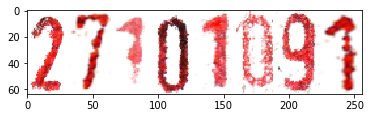

In [20]:
plt.imshow(imgs[0])
print(np.argmax(y_gt[0], axis=0))

## ConvNet

#### Definition

In [21]:
def conv2d(height, width, kernel, stride=(1,1)):
    return  int(floor((height - kernel)/stride[0] + 1))  , \
            int(floor((width - kernel )/stride[1]) + 1)

def maxpool2d(height, width, kernel, stride = 1):
    return (height//kernel)

In [22]:
height, width = (64, 256)
kernels = [3,5,14,16]
strides = [(1,1),(1,1),(2,2),(1,1)]

for n in range(len(kernels)):
    
    k = kernels[n]
    stride = strides[n]
    
    height, width =conv2d(height,width, k, stride)
    print(height, width)


62 254
58 250
23 119
8 104


# model

In [52]:
class OCR_CNN(torch.nn.Module):
    '''
    width     -> sequence length
    height    -> summed over, or max pooled
    channnels -> character classes
    
    
    img format required by pytorch 
    (N_batch,channels,Height,Width)
    '''
    
    def __init__(self):
        super(OCR_CNN, self).__init__()
        
        
        kernels = [3,5,14,16]
        strides = [(1,1),(1,1),(2,2),(1,1)] #[(1,1), (2,2), (1,3), (1,3)]
        filters = [3,16,64,64,11] # filters should grow exp?
        ## 11 channel is for 10 numbers + 1 epsilon (number 10)
        
        # conv blocks
        self.conv = []
        self.bn = torch.nn.BatchNorm2d(3)
        self.conv1 = torch.nn.Conv2d(filters[0], filters[0+1], kernels[0], stride=strides[0])
        self.conv2 = torch.nn.Conv2d(filters[1], filters[1+1], kernels[1], stride=strides[1])
#         self.conv3 = torch.nn.Conv2d(filters[2], filters[2+1], kernels[2], stride=strides[2])
        self.conv3 = torch.nn.MaxPool2d(kernels[2], stride=strides[2])
        
        self.conv4 = torch.nn.Conv2d(filters[2], filters[3+1], kernels[3], stride=strides[3])

        self.conv = [self.conv1, self.conv2, self.conv3, self.conv4]
        
#         for n in range(0,len(kernels)):    
#             self.conv.append(
#                 torch.nn.Conv2d(filters[n], filters[n+1], kernels[n], stride=strides[n])
#             )
        
        # activation
        self.activation = torch.nn.ReLU()
        self.LogSoftmax = torch.nn.LogSoftmax(dim=1)# after squezze channels are the second, third is position
        #torch.nn.LogSoftmax
    
    
    def forward(self, x):
        # incoming format: N_batch,Height,Width,channels
        # permute to:      N_batch,channels,Height,Width
        #with torch.cuda.device(0):
        with torch.autograd.detect_anomaly():
            x = x.permute((0,3,1,2))

            x = self.bn(x) 


            for conv in self.conv[0:-1]:
                x = conv(x)
                x = self.activation(x)
                # You can always leverage the fact that nan != nan


            x = self.conv[-1](x) # last conv 

            # height dim (1st) is 1, so contract

            # max returns: torch.max returns a tuple (max_values, indices)
            x = torch.max(x, 2)[0] # [batch, n_filters, 1 vertical, 8 horizontal pos]       
            #x = torch.squeeze(x, 2) # [batch, n_filters, 1 vertical, 8 horizontal pos]       

            # add 1x1 convolution layer ?

            x = self.LogSoftmax(x) # [softmax over n_filters i.e. char probs]
            #pdb.set_trace()
        
        return x
    
    

## model test

In [53]:
#Helper to count params
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [54]:
model = OCR_CNN()

In [55]:
count_parameters(model)

206353

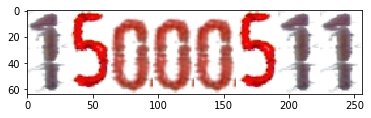

In [214]:
#img, text = random_stamp_numbers(char_img)
#x = torch.tensor(np.expand_dims(img, axis=0)).cpu()

imgs, y_gt = next(gen_val)
x = torch.tensor(imgs).float()

y_hat = model(x) # 

#y_hat = torch.transpose(y_hat, 0, 2) 
#y_hat = torch.transpose(y_hat, 1, 2)

# %debug

plt.imshow(imgs[0])

In [106]:
y_hat.shape # Batch, Char_classes, Width
 #ctc needs: width, batch, char_class



torch.Size([64, 11, 104])

In [78]:
# the format needed for CTC loss
y_hat.permute(2, 0, 1).shape

torch.Size([104, 64, 11])

In [79]:
#%debug

#### CTC loss test

In [210]:
y_gt = torch.argmax( torch.tensor(y_gt), axis=1 )

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [81]:
n_characters_target = y_gt.shape[1]

In [89]:
n_batches, n_character_classes, n_characters  = y_hat.shape

In [90]:
input_lengths  = torch.full( (n_batches,), n_characters, dtype=torch.long) # lengths in terms of characters
target_lengths = torch.full( (n_batches,), 8, dtype=torch.long)

In [91]:
from torch.nn.functional import ctc_loss

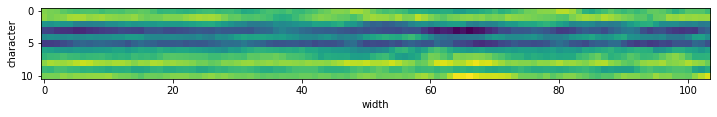

In [103]:
plt.figure(figsize=(12,4))
plt.imshow(y_hat[0,:,:].data.numpy()) # Batch, Char_classes, Width
plt.ylabel('character')
plt.xlabel('width')
plt.show()

In [211]:
y_gt

tensor([6, 0, 2, 2, 4, 3, 2, 2, 1, 6, 7, 2, 7, 0, 6, 6, 7, 4, 1, 7, 2, 3, 4, 2,
        7, 4, 5, 6, 5, 5, 6, 6, 6, 4, 0, 6, 5, 7, 3, 6, 7, 0, 0, 4, 6, 7, 3, 3,
        6, 4, 6, 3, 4, 4, 0, 3, 3, 3, 4, 5, 7, 0, 0, 3])

In [212]:
y_gt[0,:].numpy().to_list()

IndexError: too many indices for tensor of dimension 1

In [104]:
# y_gt

In [95]:
loss = ctc_loss(
    y_hat.permute(2, 0, 1), #  width, batch, char_class
    y_gt, 
    input_lengths, 
    target_lengths,
    blank=10, # label 10 is blank
    zero_infinity=True
)

In [96]:
loss

tensor(24.1938, grad_fn=<MeanBackward0>)

## Trainning

### Estimate accuracy

In [183]:
def wer(r, h):
    '''
    Word error count computation

    https://en.wikipedia.org/wiki/Word_error_rate ?
    
    sequences of integers []
    r --- prediction
    h --- ground truth

    TODO: check for correctness 
    TODO: consider adding assertions

    '''
    d = np.zeros((len(r)+1)*(len(h)+1), dtype=np.uint8)
    d = d.reshape((len(r)+1, len(h)+1)) # why not create coorect dims at start?
    for i in range(len(r)+1):
        for j in range(len(h)+1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                substitution = d[i-1][j-1] + 1
                insertion    = d[i][j-1] + 1
                deletion     = d[i-1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)

    return d[len(r)][len(h)]

In [228]:
def preds_to_integer(Preds, p_tresh = 0.5, eps = 10):
    '''`
    Preds --- (log?) probabilities [Character class, Horizontal dim]
    Batch example is selected!
    p_tresh --- treshold for character detection
    
    
    '''
    preds=torch.argmax(Preds, dim=0).detach().cpu().numpy()
    
    # take maximally likely characters
    probs=np.exp(
            np.max(Preds.detach().cpu().numpy(), axis=0)# max over probability
    )

    preds=preds.tolist()
    out = []
    
    # collapse repeating characters and epsilon
    for i in range(len(preds)):
        '''
        if char is not eps
        anf if char is not the same as previous one
        '''
        if preds[i] != eps and preds[i] != preds[i - 1]:
            if probs[i] > p_tresh: # if the character is likely enough
                out.append(preds[i])
    return out 

def wer_eval(preds, labels, ratio = False):
    '''
    Word (character) error rate evaluation
    
    preds --- log probabilities [T, C]
    
    1. Convert predictions to integers
    2. Eval WER accuracy
    
    '''
    
    preds = preds_to_integer(preds, p_tresh=0.5)
#     print('preds:', preds)
#     print('labels:', labels)
    we = wer(preds, labels)
    
    # just return nuymber of errrors 
    if ratio == False:
        return we 
    

    N = len(preds)
    
    # nothing to predict and nothing is predicted
    if len(labels) == 0 and N==0: return 0 
    
    if N==0:
        # if nothing is predicted, than we made 100% errors on each true character
        return 1

    return we/len(preds)

In [229]:
wer([1, 1], [1, 2])

1

In [230]:
y_hat.shape # width, batch, char_class

torch.Size([64, 11, 104])

In [231]:
labels = [1, 8, 1, 8, 1, 8, 1, 8, 8, 8, 0, 1, 8, 1, 8, 8, 1, 8, 2]

In [232]:
wer_eval(y_hat[0,:,:], labels)

19

## Display loss

In [233]:
from IPython import display

In [242]:
def plot_loss(LOSS, err):
    '''
    Display loss and Error rate
    '''
    
    display.clear_output(wait=True)
#     plt.clf()
#     try:
#         fig.clear()
#         plt.close(fig)
#     except:
#         pass

    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    ax[0].plot(LOSS)
    ax[0].set_title('LOSS')
    ax[0].set_xlabel('step')

    ax[1].plot(err)
    ax[1].set_title('Mean error count')
    ax[1].set_xlabel('step')

    fig.show()
    display.display(fig)
    
    fig.clear()
    plt.close(fig)

## Train for epoch


In [243]:
loss_fn = torch.nn.CrossEntropyLoss()

In [244]:
def evaluate_loss(y_gt, y_hat):
    '''
    model
    y_gt 
    y_hat --- predicted
    
    y dims: [batch, classes, char_idx]
    '''

    loss = torch.tensor(0).float().cpu()
    
    ## eval loss 
    for char_idx in range(y_hat.shape[2]):
        loss = loss + loss_fn(y_hat[:,:,char_idx], torch.argmax(y_gt[:,:,char_idx], axis=1))

    return loss

def evaluate_acc(y_gt, y_hat):
    '''
    Average symbol accuracy
    '''
    got_right = (torch.argmax(y_gt, axis = 1) == torch.argmax(y_hat, axis=1)).float()
    return torch.mean(got_right)

In [245]:
import pdb

In [246]:
def change_LR(optim, lr):
    
    for param_group in optim.param_groups:
        param_group['lr'] = lr
    

### Train

In [247]:
from torch.nn.functional import ctc_loss

In [254]:
losses = []
err_count = []

def train_for_epoch(model, optimizer, loader):
    '''
    model --- the model
    loader: for X, Y in loader:
    optimizer:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return avg_loss / len(loader)
    '''
    model.train()
    epoch_size = 100
    
    #losses = []

    for n_iter in range(epoch_size):
        x, y = next(loader)
        
        optimizer.zero_grad()
        
        y_gt = torch.tensor(y).long().cpu() # batch, char class, horizontal dim
        
        # [batch, n_filters, horizontal_pos]
        # batch, character_class, sequence_element_number
        y_hat = model(torch.tensor(x).float().cpu())
        

        # Dimensions
        #n_characters, n_batches, n_character_classes  = y_hat.shape
        n_batches, n_character_classes, n_characters  = y_hat.shape
        
        input_lengths  = torch.full( (n_batches,), n_characters, dtype=torch.long) # lengths in terms of characters
        target_lengths = torch.full( (n_batches,), n_characters_target, dtype=torch.long)

    
        # CTC loss computation
        y_gt = torch.argmax( y_gt, axis=1 ) 
        # batch, horizontal dim --- gives character index

        loss = ctc_loss(
            y_hat.permute(2, 0, 1),  # as required by CTC loss
            y_gt, 
            input_lengths, 
            target_lengths,
            blank=10, # label 10 is blank
            zero_infinity=True
        )
        
                
        # Backpropagation
        loss.backward()
        
        # Save best model
        if len(losses)>0:
            #pdb.set_trace()
            if loss.cpu().data.numpy() < np.min(losses):
                torch.save(model.state_dict(), "best_model.state_dict")
        
        # Important to append losses hera after saving best model 
        losses.append(loss.cpu().data.numpy())
        
        
        with torch.no_grad():
        
            # compute train accuracy
            #acc = evaluate_acc(y_gt, y_hat).data.numpy()
            
            
            
            # compute val accuracy
            # y_gt --- [batch idx, horizontal dim]
            err_rates = [wer_eval(y_hat[batch_idx, :, :], y_gt[batch_idx, :].numpy().tolist() ) for batch_idx in range(y_hat.shape[0])]
            
            err_count.append(np.mean(err_rates))
            
            plot_loss(losses, err_count)
        
        # update model params
        optimizer.step()
    
    return 

In [255]:
model.cpu()
from time import time
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
# model.load_state_dict(torch.load('../input/ocr-cnn-small/best_model.state_dict'))
# model.load_state_dict(torch.load('../input/ocr-cnn-small/final_model.state_dict'))

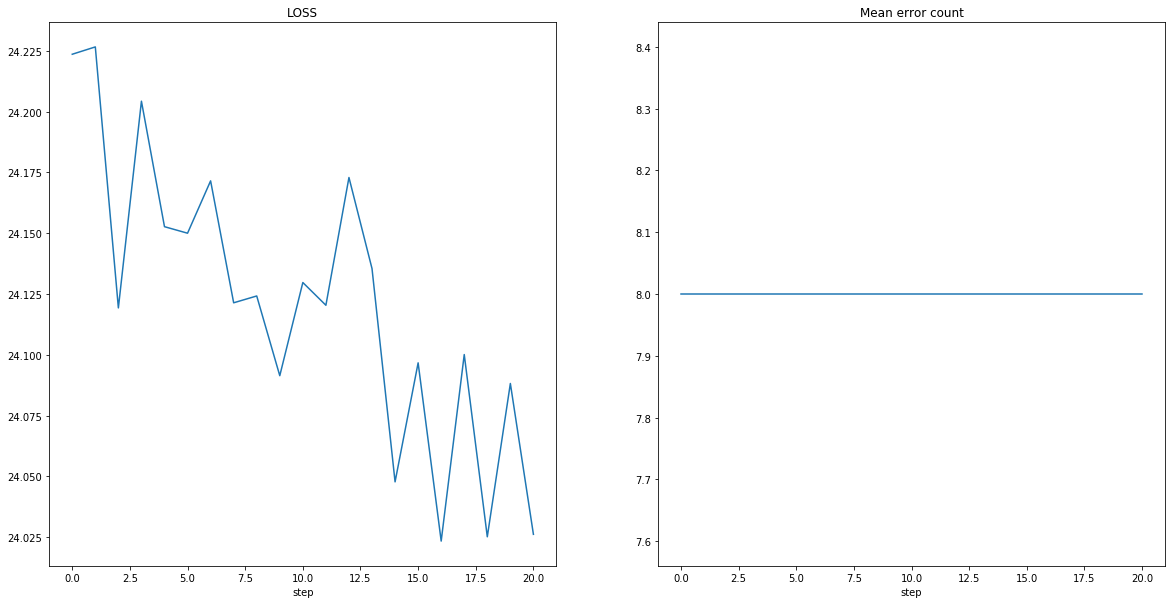

KeyboardInterrupt: 

In [256]:
t1=time()

for epoch in range(64):
    if time() - t1 > 60*60*6:
        break;

    for param_group in optim.param_groups:
        param_group['lr'] = [1e-7, 1e-8, 1e-9][epoch % 3]
#         param_group['lr'] = [1e-4, 1e-4, 1e-4, 1e-5, 1e-5, 1e-5, 1e-6][epoch % 7] # cycle

    gen_train = generator_static(char_img, batch_size = 64)

    train_for_epoch(model, optim, gen_train)

In [ ]:
%debug

In [ ]:
# optim = torch.optim.Adam(model.parameters(), lr=1e-6)

In [ ]:
torch.save(model.state_dict(), "final_model.state_dict")

In [ ]:

# for epochs in range(12):
    
#     gen_train = generator_static(char_img, batch_size = 64)
#     train_for_epoch(model, optim, gen_train)